In [77]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

%matplotlib inline

In [78]:
os.chdir('../src/')
print(os.getcwd())

C:\Users\joh3146\Documents\dssg\air_pollution_estimation\src


In [79]:
from traffic_analysis.d00_utils.load_confs import load_parameters, load_credentials, load_paths
from traffic_analysis.d00_utils.data_loader_sql import DataLoaderSQL
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_viz.d06_visualisation.chunk_evaluation_plotting import (
    plot_video_stats_diff_distribution,
    plot_video_level_summary_stats,
    plot_mAP_over_time)

params = load_parameters()
creds = load_credentials()
paths = load_paths()
pd.set_option('display.max_columns', 500)

To read in evaluation results table from sql, need to be on the ec2... otherwise can download locally as a csv and then uploaded.

In [109]:
video_performance_df = pd.read_csv("../data/eval/eval_video_performance2.csv")
video_accuracy_df = pd.read_csv("../data/eval/eval_video_diffs2.csv")
frame_accuracy_df = pd.read_csv("../data/eval/eval_frame_stats2.csv")

to make sure we evaluated some of the opencv with yolov3, they are located in the gpu dataset.

In [140]:
video_performance_gpu_df = pd.read_csv("../data/eval/eval_video_performance_gpu.csv")
video_accuracy_gpu_df = pd.read_csv("../data/eval/eval_video_diffs_gpu.csv")
frame_accuracy_gpu_df = pd.read_csv("../data/eval/eval_frame_stats_gpu.csv")

In [110]:
video_accuracy_df.stop_start_iou_threshold.unique()

array([0.75, 0.8 , 0.85, 0.9 ])

In [156]:
len(frame_accuracy_df)

22272

Merge the different grid search params into one column, divided by underscores and then convert to a lettering or other naming convention

In [141]:
columns_to_join = ['tracker_type', 'detection_model', 'detection_frequency', 
                   'detection_iou_threshold', 'stop_start_iou_threshold']

video_performance_df['model_search'] = video_performance_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_accuracy_df['model_search'] = video_accuracy_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

frame_accuracy_df['model_search'] = frame_accuracy_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_performance_gpu_df['model_search'] = video_performance_gpu_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_accuracy_gpu_df['model_search'] = video_accuracy_gpu_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

frame_accuracy_gpu_df['model_search'] = frame_accuracy_gpu_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_performance_df['model_search'].head()

0    kcf,yolov3-tiny,4,0.2,0.75
1    kcf,yolov3-tiny,4,0.2,0.75
2    kcf,yolov3-tiny,4,0.2,0.75
3    kcf,yolov3-tiny,4,0.2,0.75
4    kcf,yolov3-tiny,4,0.2,0.75
Name: model_search, dtype: object

In [113]:
video_performance_df.model_search.nunique()

96

Remove the data that contains the opencv implementations

In [158]:
eval_dfs_old = [video_performance_gpu_df, video_accuracy_gpu_df, frame_accuracy_gpu_df]

eval_dfs = []
for eval_df_old in eval_dfs_old:
    eval_df = eval_df_old[eval_df_old.detection_model == 'yolov3_opencv']
    eval_dfs.append(eval_df)

eval_dfs[0].detection_model.unique()
len(eval_dfs[0])

1188

In [165]:


# video_performance_df.append(eval_dfs[0], ignore_index=True)
# video_accuracy_df.append(eval_dfs[1], ignore_index=True)
# frame_accuracy_df.append(eval_dfs[2], ignore_index=True)
# video_accuracy_df.detection_model.unique()
video_performance_df = pd.concat([video_performance_df, eval_dfs[0]])
video_accuracy_df = pd.concat([video_accuracy_df, eval_dfs[1]])
frame_accuracy_df = pd.concat([frame_accuracy_df, eval_dfs[2]])
frame_accuracy_df.detection_model.unique()

C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dssg\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dssg\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


array(['yolov3-tiny', 'yolov3_opencv'], dtype=object)

See if the number of cameras evaluated among model implementations is consistent 

In [166]:
video_performance_df.columns
video_performance_df.n_videos.unique()

array([63, 73, 71, 25, 23, 21], dtype=int64)

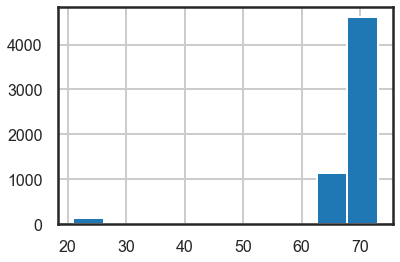

In [167]:
video_performance_df.n_videos.hist()

In [168]:
video_accuracy_df['camera_id'] = video_accuracy_df['camera_id'].astype(str)
video_accuracy_df['video_id'] = video_accuracy_df.camera_id + '_' + video_accuracy_df.video_upload_datetime
video_accuracy_df.video_id.nunique()

70

Since it's inconsistent in total number of videos analyzed, need to see if the 42 videos in the min is at least consistent among all videos.

In [169]:
video_performance_df.columns
video_performance_df.model_search[video_performance_df.n_videos == 63].unique()
video_performance_df.detection_iou_threshold[video_performance_df.n_videos == 63].unique()

array([0.2, 0.3, 0.4, 0.5])

In [170]:
models_with_min_num_vids = video_performance_df.model_search[video_performance_df.n_videos == 63].unique()
vids_in_min_num_vids = [video_accuracy_df.video_id[
    video_accuracy_df.model_search == model].values for model in models_with_min_num_vids]

video_accuracy_filtered_df = video_accuracy_df[video_accuracy_df.video_id.isin(vids_in_min_num_vids[0])]
n_vid = video_accuracy_filtered_df.video_id.nunique()
n_vid

63

the 42 videos are at least consistent. yay.

In [171]:
frame_accuracy_df['camera_id'] = frame_accuracy_df['camera_id'].astype(str)
frame_accuracy_df['video_id'] = frame_accuracy_df.camera_id + '_' + frame_accuracy_df.video_upload_datetime

vids_in_min_num_vids = [frame_accuracy_df.video_id[
    frame_accuracy_df.model_search == model].values for model in models_with_min_num_vids]

frame_accuracy_filtered_df = frame_accuracy_df[frame_accuracy_df.video_id.isin(vids_in_min_num_vids[0])]
frame_accuracy_filtered_df.video_id.nunique()

58

not sure why frame_accuracy_filtered has 38 videos = different?

In [172]:
counts_diff_df = video_accuracy_filtered_df.groupby(['vehicle_type', 'model_search', 'video_id']).counts_diff.agg(sum).reset_index()
counts_diff_df.head()

,vehicle_type,model_search,video_id,counts_diff
0,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-20 02:59:03,0
1,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-20 05:58:17,-2
2,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-27 03:01:57,0
3,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-28 13:03:00,0
4,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-29 13:01:03,0


In [173]:
counts_diff_df['abs_counts_diff'] = counts_diff_df.counts_diff.apply(lambda x: abs(x))
counts_diff_df.head()

,vehicle_type,model_search,video_id,counts_diff,abs_counts_diff
0,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-20 02:59:03,0,0
1,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-20 05:58:17,-2,2
2,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-27 03:01:57,0,0
3,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-28 13:03:00,0,0
4,bus,"csrt,yolov3-tiny,4,0.2,0.75",1.01252_2019-06-29 13:01:03,0,0


In [174]:
vid_level_model_comparison_df = counts_diff_df.groupby(
    ['model_search', 'video_id'])['counts_diff', 'abs_counts_diff'].agg(sum).reset_index()
vid_level_model_comparison_df.columns

Index(['model_search', 'video_id', 'counts_diff', 'abs_counts_diff'], dtype='object')

In [175]:
vid_level_model_comparison_df.rename(columns={'abs_counts_diff' : 'abs_counts_diff_by_veh_type'}, inplace=True)
vid_level_model_comparison_df['abs_counts_diff_on_vid_level'] = vid_level_model_comparison_df.counts_diff.apply(
    lambda x: abs(x))

model_comparison_df = vid_level_model_comparison_df.groupby(
    ['model_search'])['abs_counts_diff_on_vid_level', 'abs_counts_diff_by_veh_type'].agg(sum).reset_index()

In [176]:
model_comparison_df.abs_counts_diff_on_vid_level = model_comparison_df.abs_counts_diff_on_vid_level / n_vid
model_comparison_df.abs_counts_diff_by_veh_type = model_comparison_df.abs_counts_diff_by_veh_type / n_vid
model_comparison_df.rename(columns={
    'abs_counts_diff_on_vid_level' : 'bias', 'abs_counts_diff_by_veh_type' : 'mae'}, inplace=True)
model_comparison_df.head()

,model_search,bias,mae
0,"csrt,yolov3-tiny,4,0.2,0.75",4.492063,5.984127
1,"csrt,yolov3-tiny,4,0.2,0.8",4.492063,5.984127
2,"csrt,yolov3-tiny,4,0.2,0.85",4.492063,5.984127
3,"csrt,yolov3-tiny,4,0.2,0.9",4.492063,5.984127
4,"csrt,yolov3-tiny,4,0.3,0.75",4.984127,6.539683


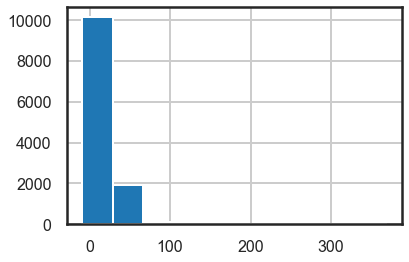

In [177]:
counts_diff_df[counts_diff_df.vehicle_type == 'car'].counts_diff.hist()

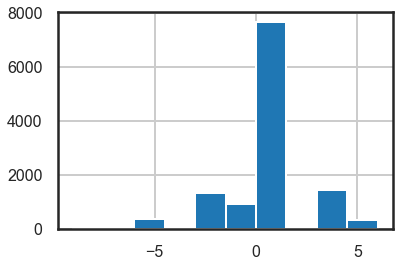

In [178]:
counts_diff_df[counts_diff_df.vehicle_type == 'bus'].counts_diff.hist()

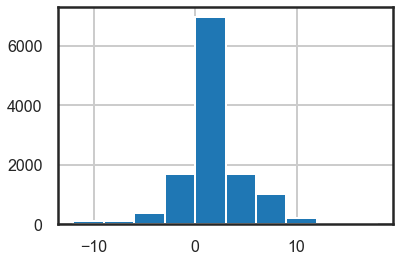

In [179]:
counts_diff_df[counts_diff_df.vehicle_type == 'truck'].counts_diff.hist()

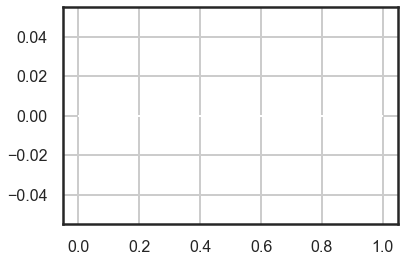

In [180]:
counts_diff_df[counts_diff_df.vehicle_type == 'motorcycle'].counts_diff.hist()

seems like we're always overpredicting cars but slightly underpredicting trucks and buses.

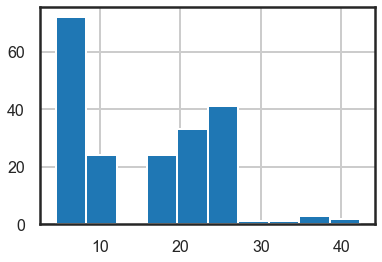

In [181]:
model_comparison_df.bias.hist()

In [182]:
speed_df = video_performance_df.groupby(['model_search']).avg_analyser_runtime.mean().reset_index()
model_comparison_df = model_comparison_df.merge(speed_df, on = 'model_search')
model_comparison_df.head()

,model_search,bias,mae,avg_analyser_runtime
0,"csrt,yolov3-tiny,4,0.2,0.75",4.492063,5.984127,12.618413
1,"csrt,yolov3-tiny,4,0.2,0.8",4.492063,5.984127,12.650582
2,"csrt,yolov3-tiny,4,0.2,0.85",4.492063,5.984127,12.673072
3,"csrt,yolov3-tiny,4,0.2,0.9",4.492063,5.984127,12.618461
4,"csrt,yolov3-tiny,4,0.3,0.75",4.984127,6.539683,13.510668


what is the fastest and the most accurate model? are they the same?

In [183]:
accurate_model_idx = model_comparison_df.mae.idxmin()
accurate_model = model_comparison_df.model_search[accurate_model_idx]

# fastest_model_idx = model_comparison_df[model_comparison_df.avg_analyser_runtime < 1].mae.idxmin()
# fastest_model = model_comparison_df.model_search[fastest_model_idx]

best_model_idx = model_comparison_df[model_comparison_df.avg_analyser_runtime < 4.8].mae.idxmin()
best_model = model_comparison_df.model_search[best_model_idx]

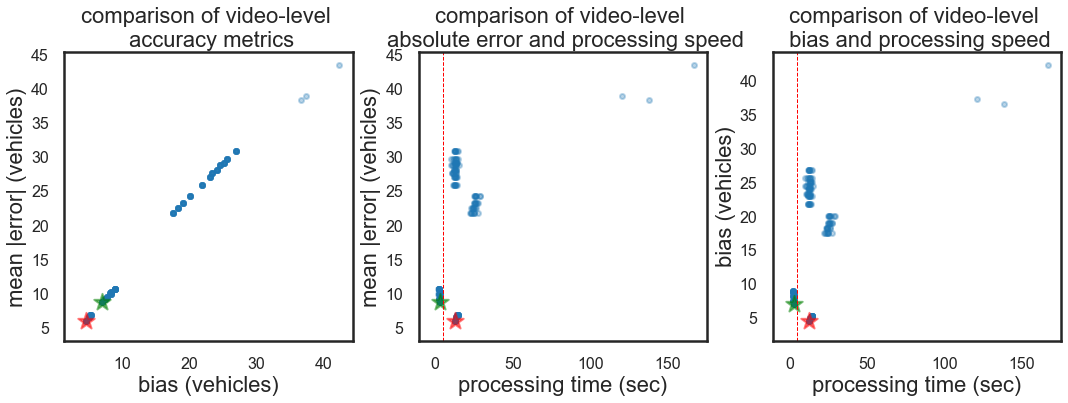

In [184]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
plt.tight_layout()


SMALL_SIZE=16
MEDIUM_SIZE=22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

ax[0].scatter(model_comparison_df.bias,
              model_comparison_df.mae,
              s=25, alpha=0.3, label='model_ensemble'
             )

ax[0].scatter(model_comparison_df.bias[best_model_idx],
            model_comparison_df.mae[best_model_idx],
            label='lowest error model above speed threshold', s=300, alpha=0.5, color='green', marker='*'
           )

ax[0].scatter(model_comparison_df.bias[accurate_model_idx],
            model_comparison_df.mae[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )


ax[0].set_xlabel('bias (vehicles)')
ax[0].set_ylabel('mean |error| (vehicles)')
ax[0].set_title('comparison of video-level \n accuracy metrics');


ax[1].scatter(model_comparison_df.avg_analyser_runtime,
            model_comparison_df.mae,
            label='model ensemble', s=25, alpha=0.3
           )

ax[1].scatter(model_comparison_df.avg_analyser_runtime[best_model_idx],
            model_comparison_df.mae[best_model_idx],
            label='lowest error model above speed threshold', color='green', s=300, alpha=0.5, marker='*'
           )

ax[1].scatter(model_comparison_df.avg_analyser_runtime[accurate_model_idx],
            model_comparison_df.mae[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )

ax[1].set_xlabel('processing time (sec)')
ax[1].set_ylabel('mean |error| (vehicles)')
ax[1].set_title('comparison of video-level \n absolute error and processing speed')
ax[1].axvline(4.8, color='red', label='speed threshold', lw=1, ls='--')


ax[2].scatter(model_comparison_df.avg_analyser_runtime,
            model_comparison_df.bias,
            label='model ensemble', s=25, alpha=0.3
           )

ax[2].scatter(model_comparison_df.avg_analyser_runtime[best_model_idx],
            model_comparison_df.bias[best_model_idx],
            label='lowest error model above speed threshold', color='green', s=300, alpha=0.5, marker='*'
           )

ax[2].scatter(model_comparison_df.avg_analyser_runtime[accurate_model_idx],
            model_comparison_df.bias[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )

ax[2].set_xlabel('processing time (sec)')
ax[2].set_ylabel('bias (vehicles)')
ax[2].set_title('comparison of video-level \n bias and processing speed')
ax[2].axvline(4.8, color='red', label='speed threshold', lw=1, ls='--')

# ax[2].legend();

In [185]:
model_comparison_df.model_search.nunique()

195

In [186]:
model_comparison_df.iloc[best_model_idx]

model_search            kcf,yolov3-tiny,4,0.2,0.75
bias                                       6.98413
mae                                         8.8254
avg_analyser_runtime                       2.92786
Name: 64, dtype: object

In [187]:
model_comparison_df.iloc[accurate_model_idx]

model_search            csrt,yolov3-tiny,4,0.2,0.75
bias                                        4.49206
mae                                         5.98413
avg_analyser_runtime                        12.6184
Name: 0, dtype: object